In [ ]:
# Bibliotecas
import scipy.sparse as sp, scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import pickle, os
import numpy as np
from scipy.integrate import solve_ivp



$ \ V = V_0 e^{-ωt} cos(ωt + ϕ) $ Ejemplo de código LaTex en Notebook

In [ ]:
# Parámetros físicos del sistema
rho = 1200          # Densidad [kg/m^3]
eta = 1.2           # Viscosidad [Pa·s]
epsilon = 8.85e-12  # Permitividad del vacío [F/m]
V = 15000           # Voltaje aplicado [V]
d = 0.15            # Distancia aguja-colector [m]
Q = 1e-8            # Caudal volumétrico [m^3/s]


In [ ]:
E = V / d  # Campo eléctrico aproximado [V/m]


In [ ]:
def jet_dynamics(z, y):
    v, r = y  # velocidad y radio del jet
    dv_dz = (epsilon * E**2 / (2 * rho)) - (eta / rho) * v / r**2
    dr_dz = -v / 10  # tasa de estiramiento aproximada
    return [dv_dz, dr_dz]

z_span = (0, d)
y0 = [0, 1e-3]  # velocidad inicial y radio inicial [m]
sol = solve_ivp(jet_dynamics, z_span, y0, max_step=0.1)


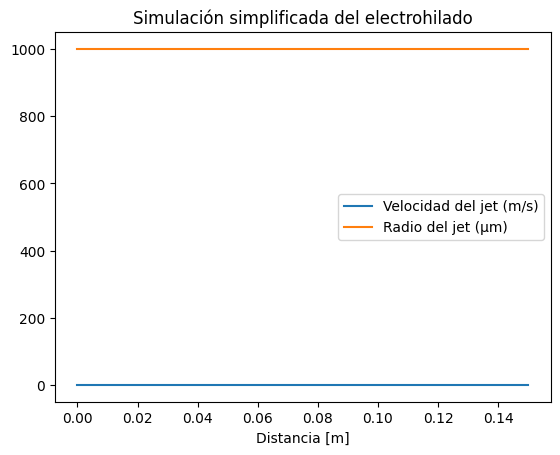

In [ ]:
plt.plot(sol.t, sol.y[0], label='Velocidad del jet (m/s)')
plt.plot(sol.t, sol.y[1]*1e6, label='Radio del jet (µm)')
plt.xlabel('Distancia [m]')
plt.legend()
plt.title('Simulación simplificada del electrohilado')
plt.show()


#**Código ampliado**

In [ ]:
# Implementación avanzada: Laplace 2D (FD) + modelo 1D de filamento viscoelástico (Maxwell)
# + término de tensión superficial + simple aumento de viscosidad por "evaporación"
# + generación de dataset sintético y RandomForest para predecir diámetro.


# -------------------- 1) Laplace 2D (FD) --------------------
def solve_laplace_2d(nx=160, ny=300, needle_x_frac=0.5, needle_y_frac=0.05, Vneedle=15000.0):
    Lx, Ly = 1.0, 1.0
    nx, ny = int(nx), int(ny)
    dx, dy = Lx/(nx-1), Ly/(ny-1)
    N = nx*ny
    def idx(i,j): return j*nx + i
    data, rows, cols = [], [], []
    b = np.zeros(N)
    needle_i = int(needle_x_frac*(nx-1))
    needle_j = int(needle_y_frac*(ny-1))
    needle_radius = max(1, int(0.01*nx))
    for j in range(ny):
        for i in range(nx):
            p = idx(i,j)
            if j == ny-1:
                rows.append(p); cols.append(p); data.append(1.0); b[p]=0.0; continue
            if (i-needle_i)**2 + (j-needle_j)**2 <= needle_radius**2:
                rows.append(p); cols.append(p); data.append(1.0); b[p]=Vneedle; continue
            if i==0 or i==nx-1 or j==0:
                rows.append(p); cols.append(p); data.append(1.0); continue
            rows += [p,p,p,p,p]
            cols += [p, idx(i-1,j), idx(i+1,j), idx(i,j-1), idx(i,j+1)]
            data += [-4.0,1.0,1.0,1.0,1.0]
    A = sp.csr_matrix((data,(rows,cols)), shape=(N,N))
    phi = spla.spsolve(A,b).reshape((ny,nx))
    x = np.linspace(0,Lx,nx); y = np.linspace(0,Ly,ny)
    return x,y,phi,dx,dy

In [ ]:
# Baseline E along axis (unit domain), rescalable
x,y,phi,dx,dy = solve_laplace_2d(nx=160, ny=300, Vneedle=15000.0)
Ey, Ex = np.gradient(-phi, dy, dx)
E_mag = np.sqrt(Ex**2 + Ey**2)
ix_center = int(0.5*(len(x)-1))
E_along_y = E_mag[:, ix_center]

def scaled_E_axis(V_sample, d_phys, E_along_y=E_along_y):
    return E_along_y / np.max(E_along_y) * (V_sample / d_phys)

In [ ]:
# -------------------- 2) Viscoelastic filament model --------------------
rho = 1200.0  # density kg/m3

def simulate_filament(V_sample=15000.0, Q_sample=1e-8, eta0=1.0, lambda_relax=0.05, gamma=0.03,
                      sigma_cond=1e-6, d_phys=0.15, charge_factor=1e-6, evap_rate=0.0):
    """
    Returns z_sol, v_sol, r_sol, S_sol, final_diameter (m)
    - Variables:
        v(z): axial velocity
        S(z): axial elastic stress (Pa)
        r(z): radius from mass conservation r = sqrt(Q / (pi v))
    - Physics (simplified):
        dv/dz = (F_electrical + F_elastic - F_surface - F_viscous) / mass_per_length
        dS/dz = (G * dv/dz - S/lambda) / v  (converted Maxwell eqn via d/dt = v d/dz)
        viscosity increases as eta(z) = eta0 * exp(evap_rate * z)
    """
    E_axis = scaled_E_axis(V_sample, d_phys)
    z_grid = np.linspace(0, d_phys, len(E_axis))
    G = eta0 / max(lambda_relax,1e-9)
    def odes(z, y):
        v, S = y
        v = max(v, 1e-9)
        r = np.sqrt(Q_sample / (np.pi * v))
        eta_local = eta0 * np.exp(evap_rate * z)
        epsilon0 = 8.85e-12
        E_local = np.interp(z, z_grid, E_axis)
        Fe_per_length = charge_factor * epsilon0 * E_local**2 * (1.0 + sigma_cond*1e3)
        Felastic_per_length = 2.0 * np.pi * r * S
        Fsurf_per_length = 2.0 * np.pi * gamma
        Fvisc_per_length = eta_local * v / (r**2 + 1e-12)
        mass_per_length = rho * np.pi * r**2
        dv_dz = (Fe_per_length + Felastic_per_length - Fsurf_per_length - Fvisc_per_length) / (mass_per_length + 1e-12)
        if v > 1e-12:
            dS_dz = (G * dv_dz - S / lambda_relax) / v
        else:
            dS_dz = - S / (lambda_relax + 1e-12)
        return [dv_dz, dS_dz]
    y0 = [0.01, 0.0]
    sol = solve_ivp(odes, (0, d_phys), y0, max_step=d_phys/1000, dense_output=True)
    z_sol = sol.t
    v_sol = sol.y[0]
    S_sol = sol.y[1]
    r_sol = np.sqrt(Q_sample / (np.pi * np.maximum(v_sol, 1e-12)))
    diam_sol = 2.0 * r_sol
    return z_sol, v_sol, r_sol, S_sol, diam_sol[-1]

In [ ]:
# Example quick run and plotting
if __name__ == "__main__":
    z_sol, v_sol, r_sol, S_sol, final_diam = simulate_filament()
    print(f"Ejemplo: diámetro final (modelo viscoelástico simplificado): {final_diam*1e6:.3f} µm")
    import matplotlib.pyplot as plt
    plt.figure(); plt.plot(z_sol, v_sol); plt.xlabel('z (m)'); plt.ylabel('v (m/s)'); plt.title('Velocidad'); plt.show()
    plt.figure(); plt.plot(z_sol, 2*r_sol*1e6); plt.xlabel('z (m)'); plt.ylabel('diámetro (µm)'); plt.title('Diámetro'); plt.gca().invert_xaxis(); plt.show()
    plt.figure(); plt.plot(z_sol, S_sol); plt.xlabel('z (m)'); plt.ylabel('S (Pa)'); plt.title('Tensión elástica'); plt.show()


In [ ]:
# -------------------- 3) Crear dataset sintético y entrenar RF --------------------
    np.random.seed(0)
    n_samples = 200
    V_samples = np.random.uniform(5000,30000,n_samples)
    Q_samples = np.random.uniform(1e-9,5e-8,n_samples)
    eta_samples = np.random.uniform(0.1,5.0,n_samples)
    lambda_samples = np.random.uniform(0.01,0.2,n_samples)
    gamma_samples = np.random.uniform(0.02,0.06,n_samples)
    sigma_samples = np.random.uniform(1e-8,1e-4,n_samples)
    evap_samples = np.random.uniform(0.0,8.0,n_samples)

    results = []
    for V_s,Q_s,eta_s,lmbd_s,gam_s,sig_s,ev_s in zip(V_samples,Q_samples,eta_samples,lambda_samples,gamma_samples,sigma_samples,evap_samples):
        try:
            _,_,_,_,d_out = simulate_filament(V_sample=V_s, Q_sample=Q_s, eta0=eta_s, lambda_relax=lmbd_s,
                                              gamma=gam_s, sigma_cond=sig_s, evap_rate=ev_s)
        except Exception:
            d_out = np.nan
        results.append(d_out)
    df = pd.DataFrame({
        'V': V_samples,
        'Q': Q_samples,
        'eta0': eta_samples,
        'lambda': lambda_samples,
        'gamma': gamma_samples,
        'sigma': sigma_samples,
        'evap_rate': evap_samples,
        'diam_m': results
    }).dropna()
    print(f"Dataset válido: {len(df)} muestras")

    features = ['V','Q','eta0','lambda','gamma','sigma','evap_rate']
    X = df[features].values
    y = df['diam_m'].values * 1e6  # micras
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=2)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("R2:", r2_score(y_test, y_pred), "MAE:", mean_absolute_error(y_test, y_pred))
    # guardar
    os.makedirs('./electrospin_outputs', exist_ok=True)
    df.to_csv('./electrospin_outputs/synthetic_visco_dataset.csv', index=False)
    with open('./electrospin_outputs/rf_visco.pkl','wb') as f: pickle.dump(rf, f)
    print("Archivos guardados en ./electrospin_outputs/")

#**Simulación Final**

##Pruebas

In [ ]:
# Bibliotecas
import scipy.sparse as sp, scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import pickle, os
import numpy as np
from scipy.integrate import solve_ivp
import plotly.graph_objects as go

In [ ]:
import numpy as np

In [ ]:
def generate_adaptive_mesh(n_fine, n_coarse, ratio):
    n_refined = max(5, int(n_fine * ratio))
    n_coarse_segment = max(5, int(n_coarse))

    fine = np.linspace(0, 1, n_refined)
    coarse = np.linspace(1, 2, n_coarse_segment)[1:]

    mesh = np.concatenate((fine, coarse))
    mesh = mesh / mesh[-1]
    return mesh

In [ ]:
np.diff(generate_adaptive_mesh(100, 101, 1))

array([0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505051,
       0.00505051, 0.00505051, 0.00505051, 0.00505051, 0.00505

In [ ]:
len(generate_adaptive_mesh(160, 60, 0.35))

115

In [ ]:
np.diff(generate_adaptive_mesh(160, 60, 0.35))

array([0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00909091, 0.00909091, 0.00909091, 0.00909091, 0.00909091,
       0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458,
       0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458,
       0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847458,
       0.00847458, 0.00847458, 0.00847458, 0.00847458, 0.00847

In [ ]:
nx, ny = 115, 115
dx = np.diff(generate_adaptive_mesh(160, 60, 0.35))
dy = np.diff(generate_adaptive_mesh(160, 60, 0.35))

In [ ]:
phi = np.zeros((ny, nx), dtype=np.float32)

In [ ]:
phi[0, :]  = 15000   # electrodo (alto voltaje)
phi[-1, :] = 0.0   # colector

In [ ]:
phi

array([[15000., 15000., 15000., ..., 15000., 15000., 15000.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       ...,
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.]],
      dtype=float32)

##Código formal

In [ ]:
# ============================================================
#       SOLVER LAPLACE 2D ADAPTATIVO + INTEGRACIÓN COMPLETA
# ============================================================

#######################################################################
# 1) Malla adaptativa
#######################################################################
#Datos que usa la función:
n_fine=160
n_coarse=60
ratio=0.35

def generate_adaptive_mesh(n_fine, n_coarse, ratio=0.35):
    n_refined = max(5, int(n_fine * ratio))
    n_coarse_segment = max(5, int(n_coarse))

    fine = np.linspace(0, 1, n_refined)
    coarse = np.linspace(1, 2, n_coarse_segment)[1:]

    mesh = np.concatenate((fine, coarse))
    mesh = mesh / mesh[-1]
    return mesh


#######################################################################
# 2) Solver Laplace adaptativo
#######################################################################
#Datos que usa la función:
nx_fine=160
ny_fine=160
n_coarse=60
omega=1.85
tol=1e-4
max_iter=6000
V = 15000

def solve_laplace_adaptive(nx_fine, ny_fine, n_coarse,
                           omega, tol, max_iter,V):

    x = generate_adaptive_mesh(nx_fine, n_coarse)
    y = generate_adaptive_mesh(ny_fine, n_coarse)

    nx, ny = len(x), len(y)
    dx = np.diff(x)
    dy = np.diff(y)

    phi = np.zeros((ny, nx), dtype=np.float32)

    # Condiciones de frontera típicas del electrohilado
    phi[0, :]  = V   # electrodo (alto voltaje)
    phi[-1, :] = 0.0   # colector

    for k in range(max_iter):

        phi_old = phi.copy()

        for j in range(1, ny-1):
            for i in range(1, nx-1):

                dx1 = dx[i-1]
                dx2 = dx[i]
                dy1 = dy[j-1]
                dy2 = dy[j]

                ax = 2 / (dx1 * (dx1 + dx2))
                bx = 2 / (dx2 * (dx1 + dx2))
                ay = 2 / (dy1 * (dy1 + dy2))
                by = 2 / (dy2 * (dy1 + dy2))

                gs = (ax * phi[j, i-1] + bx * phi[j, i+1] +
                      ay * phi[j-1, i] + by * phi[j+1, i]) / (ax + bx + ay + by)

                phi[j, i] = (1 - omega)*phi[j, i] + omega*gs

        if np.max(np.abs(phi - phi_old)) < tol:
            break

    return phi, x, y


#######################################################################
# 3) Campo eléctrico adaptativo
#######################################################################

def compute_E_adaptive(phi, x, y):
    ny, nx = phi.shape
    Ex = np.zeros_like(phi)
    Ey = np.zeros_like(phi)

    for j in range(1, ny-1):
        for i in range(1, nx-1):
            Ex[j, i] = -(phi[j, i+1] - phi[j, i-1]) / (x[i+1] - x[i-1])
            Ey[j, i] = -(phi[j+1, i] - phi[j-1, i]) / (y[j+1] - y[j-1])

    return Ex, Ey


#######################################################################
# 4) Extraer E en el eje, reescalar al sistema físico (V y distancia)
#######################################################################

def get_E_profile(V_applied, distance_m, nx=160, ny=160):
    """
    Obtiene E(y) físico sobre el eje central del jet:
        - resuelve Laplace adaptativo
        - obtiene Ey en el eje
        - lo reescala a V_applied y distance_m reales
    """

    phi, x, y = solve_laplace_adaptive(nx_fine=nx, ny_fine=ny)
    Ex, Ey = compute_E_adaptive(phi, x, y)

    # Eje central
    i_center = phi.shape[1] // 2
    Ey_axis = Ey[:, i_center]

    # Escalamiento físico:
    # La solución numérica corresponde al caso V=1 y distancia=1
    # Por lo tanto:
    #     E_real = Ey_num * (V_applied / distance_m)
    Ey_axis_real = Ey_axis * (V_applied / distance_m)

    # Devolver coordenadas físicas
    y_phys = y * distance_m

    return y_phys, Ey_axis_real


#######################################################################
# 5) Integración con el MODELO 1D DEL JET
#######################################################################

def run_jet_simulation(V, d, params):
    """
    Se usa E(y) adaptativo dentro del modelo del jet 1D.
    params: diccionario con parámetros físicos del modelo.
    """
    y, E_axis = get_E_profile(V, d, nx=140, ny=140)

    # Aquí insertamos tu modelo del jet usando solve_ivp,
    # pero reemplazamos el campo eléctrico con E_axis interpolado.
    from scipy.integrate import solve_ivp

    def jet_model(z, y_vec):
        v, r, S = y_vec   # ejemplificando tu modelo 1D
        E_local = np.interp(z, y, E_axis)

        # Fuerza electrostática + efectos viscoelásticos
        dv_dz = params["k_e"] * E_local - params["mu"] * v
        dr_dz = -params["alpha"] * r * v
        dS_dz = params["beta"] * v - params["gamma"] * S

        return [dv_dz, dr_dz, dS_dz]

    sol = solve_ivp(jet_model, [0, d], params["y0"], max_step=0.002)

    return sol, y, E_axis


#######################################################################
# 6) Integración con el DATASET SINTÉTICO
#######################################################################

def generar_dataset(N, V_range, d_range, params):
    """
    Genera dataset usando el solver adaptativo + modelo del jet.
    """
    dataset = []

    for k in range(N):
        Vk = np.random.uniform(*V_range)
        dk = np.random.uniform(*d_range)

        sol, y, Eaxis = run_jet_simulation(Vk, dk, params)
        diam_final = sol.y[1, -1] * 2e6  # diámetro final [micras]

        dataset.append([Vk, dk, diam_final])

    return np.array(dataset)


#######################################################################
# 7) INTEGRACIÓN CON LA RED NEURONAL (ML)
#######################################################################

from sklearn.ensemble import RandomForestRegressor

def entrenar_regresor(dataset):
    X = dataset[:, :2]  # V, d
    y = dataset[:, 2]   # diámetro final

    model = RandomForestRegressor(n_estimators=300)
    model.fit(X, y)

    return model


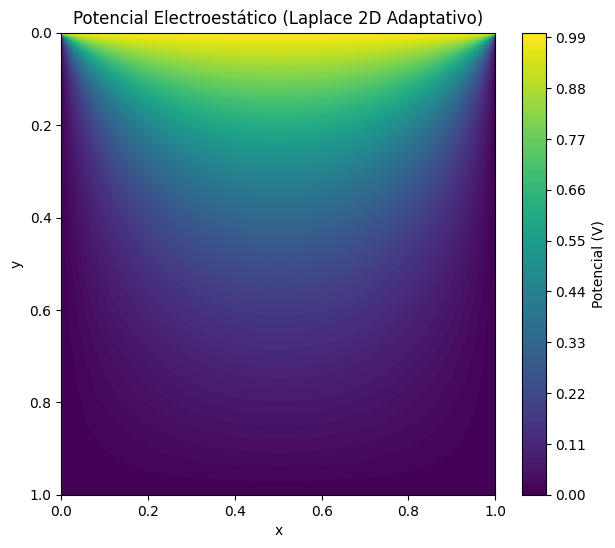

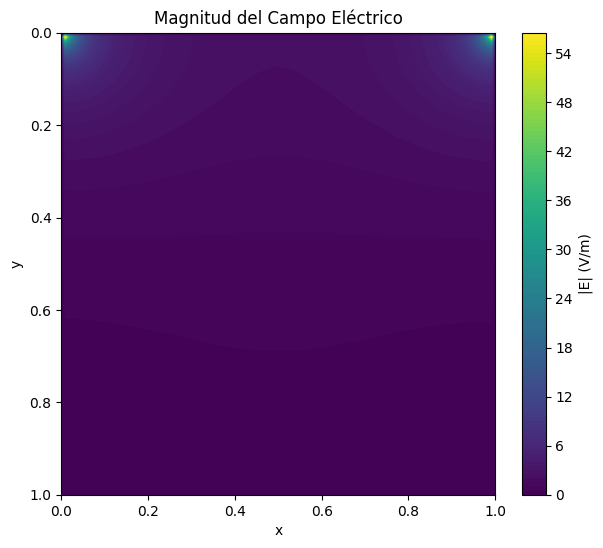

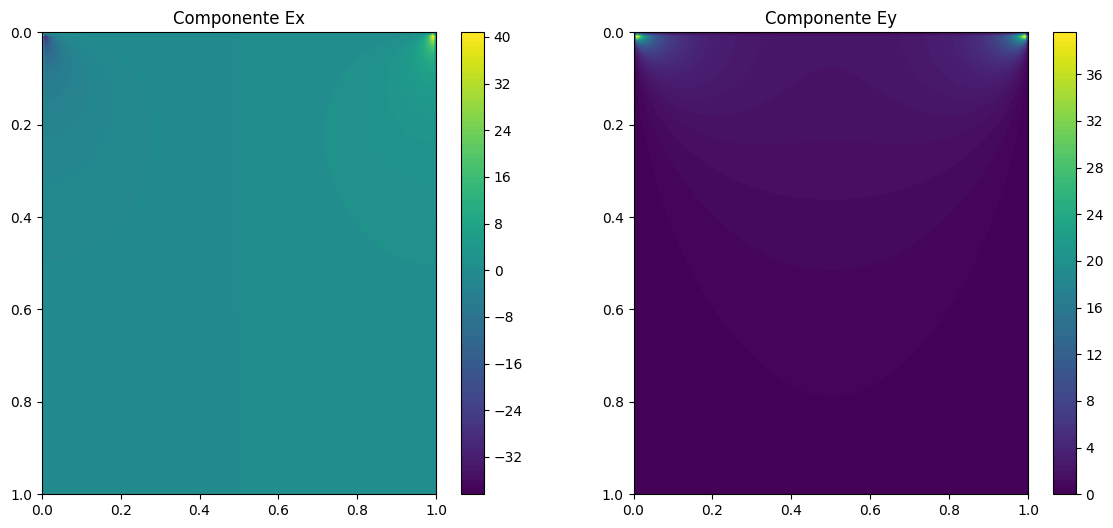

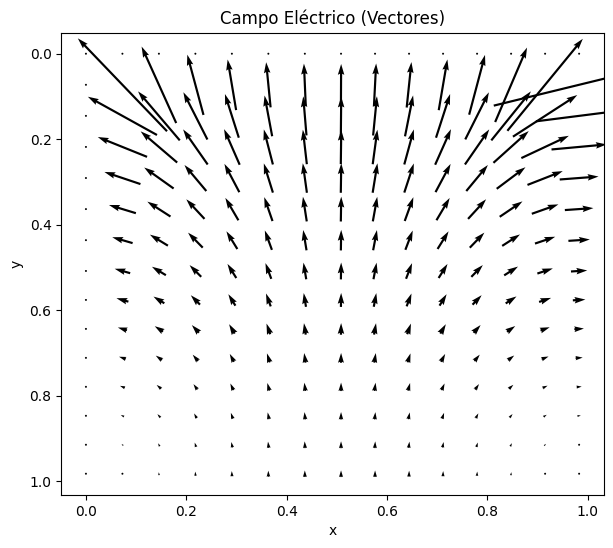

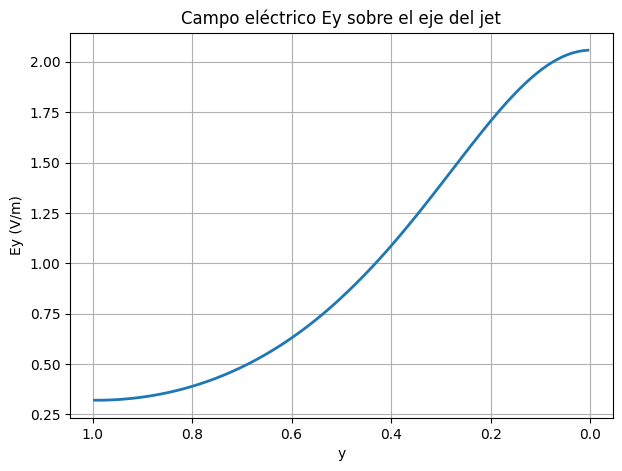

In [ ]:
# ==============================
#     1) GRAFICAR POTENCIAL
# ==============================

def plot_potential(phi, x, y):
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(7,6))
    plt.contourf(X, Y, phi, 120)
    plt.colorbar(label="Potencial (kV)")
    plt.title("Potencial Electroestático (Laplace 2D Adaptativo)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()
    plt.show()


# ==============================
#     2) GRAFICAR CAMPO |E|
# ==============================

def plot_E_magnitude(Ex, Ey, x, y):
    E = np.sqrt(Ex**2 + Ey**2)
    X, Y = np.meshgrid(x, y)

    plt.figure(figsize=(7,6))
    plt.contourf(X, Y, E, 120)
    plt.colorbar(label="|E| (V/m)")
    plt.title("Magnitud del Campo Eléctrico")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()
    plt.show()


# ====================================
#      3) GRAFICAR Ex y Ey SEPARADOS
# ====================================

def plot_Ex_Ey(Ex, Ey, x, y):
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots(1, 2, figsize=(14,6))

    c1 = ax[0].contourf(X, Y, Ex, 120)
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title("Componente Ex")
    ax[0].invert_yaxis()

    c2 = ax[1].contourf(X, Y, Ey, 120)
    fig.colorbar(c2, ax=ax[1])
    ax[1].set_title("Componente Ey")
    ax[1].invert_yaxis()

    plt.show()


# ==============================
#     4) GRAFICAR QUIVER
# ==============================

def plot_quiver(Ex, Ey, x, y, step=8):
    X, Y = np.meshgrid(x, y)
    plt.figure(figsize=(7,6))

    plt.quiver(
        X[::step,::step],
        Y[::step,::step],
        Ex[::step,::step],
        Ey[::step,::step],
        pivot='mid'
    )

    plt.title("Campo Eléctrico (Vectores)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()
    plt.show()


# ===========================================
#   5) GRAFICAR EL CAMPO EN EL EJE DEL JET
# ===========================================

def plot_axis_field(phi, x, y):
    i_center = phi.shape[1] // 2
    Ey_axis = -(phi[1:, i_center] - phi[:-1, i_center]) / np.diff(y)
    y_mid = 0.5 * (y[1:] + y[:-1])

    plt.figure(figsize=(7,5))
    plt.plot(y_mid, Ey_axis, linewidth=2)
    plt.title("Campo eléctrico Ey sobre el eje del jet")
    plt.xlabel("y")
    plt.ylabel("Ey (V/m)")
    plt.grid(True)
    plt.gca().invert_xaxis()  # porque y va de arriba (0) hacia abajo (1)
    plt.show()


# ======================================================
#     6) EJEMPLO COMPLETO: RESOLVER + GENERAR GRÁFICAS
# ======================================================

def run_all_plots():

    # Resolver Laplace con la malla adaptativa
    phi, x, y = solve_laplace_adaptive(
        nx_fine=160,
        ny_fine=160,
        n_coarse=60,
        omega=1.85,
        tol=1e-4,
        max_iter=6000,
        V = 1,
    )

    # Campo eléctrico
    Ex, Ey = compute_E_adaptive(phi, x, y)

    # Gráficas
    plot_potential(phi, x, y)
    plot_E_magnitude(Ex, Ey, x, y)
    plot_Ex_Ey(Ex, Ey, x, y)
    plot_quiver(Ex, Ey, x, y)
    plot_axis_field(phi, x, y)


# === Ejecutar todas las gráficas ===
run_all_plots()


In [ ]:
phi, x, y = solve_laplace_adaptive(
        nx_fine=160,
        ny_fine=160,
        n_coarse=60,
        omega=1.85,
        tol=1e-4,
        max_iter=6000,
        V = 15000,
    )

In [ ]:
fig = go.Figure(
    data=go.Contour(
        z=phi,
        x=x,
        y=y,
        colorscale='Viridis'
    )
)

fig.update_layout(
    title="Potencial electrostático",
    xaxis_title="x",
    yaxis_title="y"
)

#fig.write_image("fig_potencial.pdf")  # vectorial
fig.write_html("potencial.html")

In [ ]:
import kaleido

/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




In [ ]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.3 MB/s eta 0:00:00
